# Model v11

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = original.

## Set-up

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 5.8MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
     |████████████████████████████████| 163kB 54.0MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=3e8d8a1acf0394d5d1546166c00468626268783e30a26d5d49a2f11acd828e9f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 54.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

ImageFolder.ipynb  Images  Models.gdoc	Previous  v10  v11  v8	v9


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-2')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model with `get_transforms(do_flip=False)`

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
df = pd.read_csv('/gdrive/My Drive/Labeling/LabelsCSV/random_split/Metric1/all_labels_path_train.csv')
df = df.filter(items=['image', 'group_original'])
df['group_original'] = df['group_original'].astype(int).astype(str)
df.head()

,image,group_original
0,969902383s228ms.jpg,3
1,969902516s227ms.jpg,2
2,969902832s243ms.jpg,0
3,970330409s202ms.jpg,0
4,969901887s232ms.jpg,0


In [ ]:
image_path = os.path.join(path, 'Images')

print('All images:', len(os.listdir(image_path)))
print('Images in Labeling/PathDetectionClassifier/PredictImages/Path:', len(os.listdir('/gdrive/My Drive/Labeling/PathDetectionClassifier/PredictImages/Path')))
print('Images with labels in CSV (should be 80% of the images in the Path folder):', len(df))

All images: 8983
Images in Labeling/PathDetectionClassifier/PredictImages/Path: 7070
Images with labels in CSV (should be 80% of the images in the Path folder): 5656


#### Balance classes

In [ ]:
group_0 = df[df['group_original'] == '0']
group_1 = df[df['group_original'] == '1']
group_2 = df[df['group_original'] == '2']
group_3 = df[df['group_original'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

1072
2307
1287
990


In [ ]:
group_1 = group_1[:1287]
group_2 = group_2[:1287]

df_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(df_balanced))

print(len(df_balanced[df_balanced['group_original'] == '0']))
print(len(df_balanced[df_balanced['group_original'] == '1']))
print(len(df_balanced[df_balanced['group_original'] == '2']))
print(len(df_balanced[df_balanced['group_original'] == '3']))

4636
1072
1287
1287
990


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch()
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

3709 3709
927 927


In [ ]:
print(data.classes)

['0', '1', '2', '3']


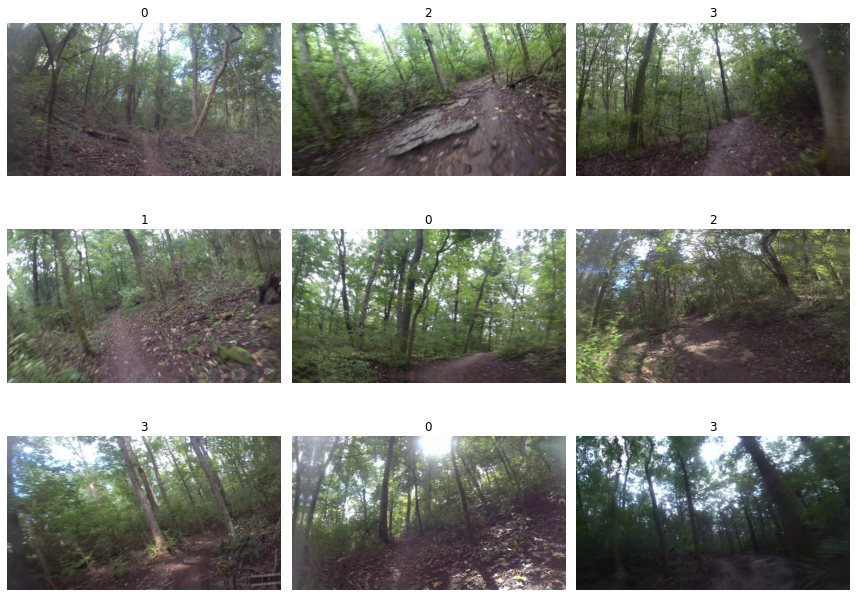

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


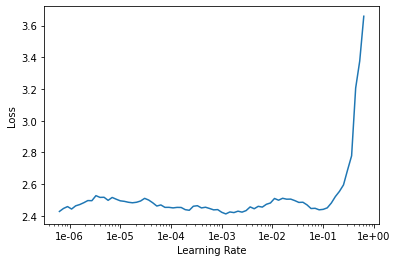

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.001

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.272850,1.765651,0.365696,26:33
1,2.123028,1.724499,0.371090,28:16
2,1.830174,1.458698,0.362460,28:41
3,1.614583,1.382865,0.382956,28:32
4,1.503439,1.377159,0.391586,28:46


Better model found at epoch 0 with valid_loss value: 1.7656506299972534.
Better model found at epoch 1 with valid_loss value: 1.7244993448257446.
Better model found at epoch 2 with valid_loss value: 1.4586976766586304.
Better model found at epoch 3 with valid_loss value: 1.382865309715271.
Better model found at epoch 4 with valid_loss value: 1.3771593570709229.
Loaded best saved model from /content/wandb/run-20201222_155112-16flwqx5/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(path, 'v11/v11-stage-1-rn50'))

In [ ]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.511464,1.393307,0.378641,28:48


Better model found at epoch 0 with valid_loss value: 1.393307089805603.
Loaded best saved model from /content/wandb/run-20201222_155112-16flwqx5/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(path, 'v11/v11-stage-1-rn50'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

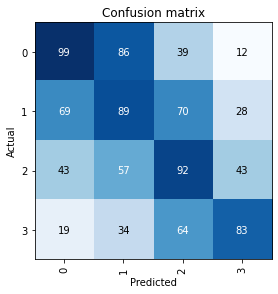

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
# bs = 64
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = bs

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.load(os.path.join(path, 'v11/v11-stage-1-rn50'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20201222_155112-16flwqx5/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


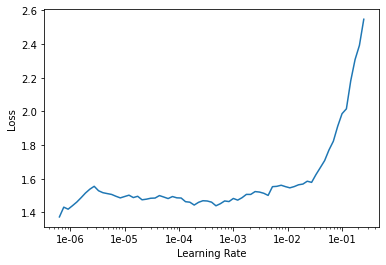

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.569968,1.472614,0.363538,28:20
1,1.505260,1.429288,0.330097,29:07
2,1.329762,1.251171,0.389428,28:52
3,1.220355,1.213694,0.420712,28:54
4,1.070358,1.194707,0.433657,29:02


Better model found at epoch 0 with valid_loss value: 1.4726136922836304.
Better model found at epoch 1 with valid_loss value: 1.4292881488800049.
Better model found at epoch 2 with valid_loss value: 1.2511712312698364.
Better model found at epoch 3 with valid_loss value: 1.2136939764022827.
Better model found at epoch 4 with valid_loss value: 1.194706916809082.
Loaded best saved model from /content/wandb/run-20201222_155112-16flwqx5/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(path, 'v11/v11-stage-2-rn50'))

In [ ]:
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.214696,1.194988,0.398058,29:09


Better model found at epoch 0 with valid_loss value: 1.1949883699417114.
Loaded best saved model from /content/wandb/run-20201222_155112-16flwqx5/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(path, 'v11/v11-stage-2-rn50'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

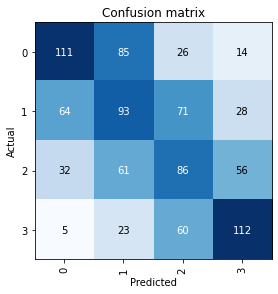

In [ ]:
interp.plot_confusion_matrix()

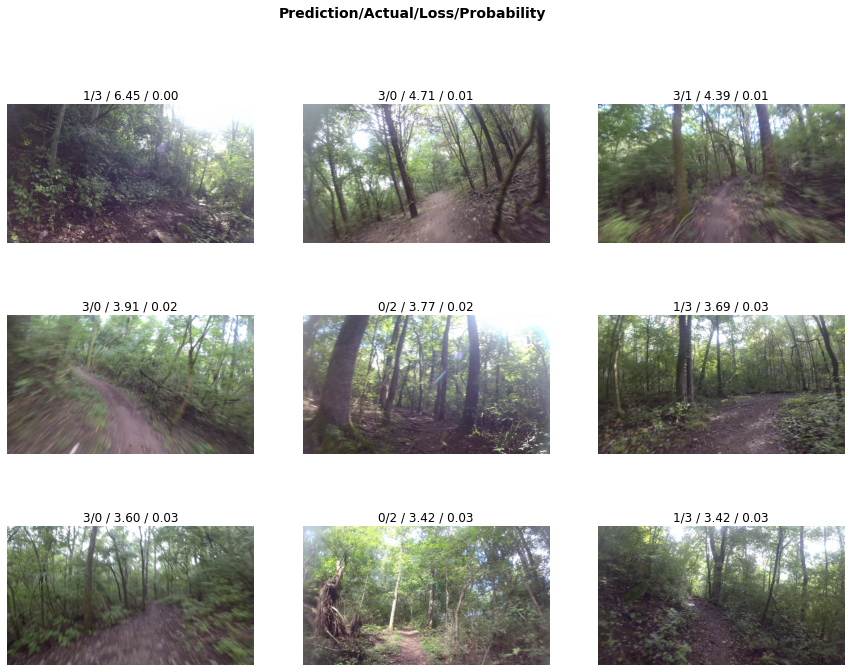

In [ ]:
 interp.plot_top_losses(9, figsize=(15,11))